In [ ]:
!pip install tensorflow
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, concatenate, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_wine

In our classes we will use TensorFlow and Keras, however, a project can be done with any technology you want. You can even use pure NumPy and implement neural networks by yourself or write it in C or Assembler.

TensorFlow by default allocates nearly all available memory on the GPU. It's wise to set the memory_growth parameter then it will take just as much memory as needed.

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, enable=True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Before we jump to neural networks let's start with a single perceptron. It's a simple mathematical model that calculates a weighted sum and applies a selected function called an activation function.

In [7]:
model = Sequential()
model.add(Dense(1, input_shape=(2,)))
# that's how we create a single layer. First parameter specifies how many neurons we want, since we want to have
# a single perceptron we use 1. Then we specify the input shape so bascially the number of variables
model.summary()

/home/determinator/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1760480266.390653   21520 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9709 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:05:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

Above we created a simple neural network with just one neuron accepting input consisting of two values. As you can see such a network/perceptron has 3 parameters. Two of them are the weights associated with each input. Additionally, there is one more parameter called bias. It can be treated as a weight associated with an additional constant input equal to one.

The formula for a single perceptron looks as follows.
$$ \sum (x_i*w_i) + bias$$

Let's check if it really works

In [8]:
model.weights

[<Variable path=sequential/dense/kernel, shape=(2, 1), dtype=float32, value=[[-1.2057145]
  [ 0.3233446]]>,
 <Variable path=sequential/dense/bias, shape=(1,), dtype=float32, value=[0.]>]

Above you should see two weights as kernel and one bias. These weights are randomly initialized. Let's see if the formula is correct.

In [9]:
x = np.array([[2,1]]) # dummy input for calculations
print("Model prediction:", model.predict(x))
print("Manual calculations:", x @ model.weights[0].numpy() + model.weights[1].numpy())

I0000 00:00:1760480267.375411   21621 service.cc:152] XLA service 0x7d0b24003400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760480267.375449   21621 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
I0000 00:00:1760480267.393684   21621 cuda_dnn.cc:529] Loaded cuDNN version 90501


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
Model prediction: [[-2.0880842]]
Manual calculations: [[-2.08808434]]


I0000 00:00:1760480267.621341   21621 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Method predict simply run neural network with given input.

Seems it works since the results are the same, btw @ is an operator for matrix multiplication. If you don't trust it you can write it step by step with scalar multiplication.

OK but what about an activation function?

That's right, here we just used linear function f(x) = x, but in general, you can use whatever function you want e.g. tanh. It's applied after the weighted sum. So let's update our formula and try it once again.
$$ f(\sum (x_i*w_i) + bias)$$

In [10]:
model = Sequential()
model.add(Dense(1, 'tanh', input_shape=(2,))) # the second parameter specifies the activation function
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.weights

[<Variable path=sequential_1/dense_1/kernel, shape=(2, 1), dtype=float32, value=[[0.2764213]
  [1.3038422]]>,
 <Variable path=sequential_1/dense_1/bias, shape=(1,), dtype=float32, value=[0.]>]

In [12]:
x = np.array([[2,1]]) # dummy input for calculations
print("Model prediction:", model.predict(x))
print("Manual calculations:", x @ model.weights[0].numpy() + model.weights[1].numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Model prediction: [[0.95237154]]
Manual calculations: [[1.8566848]]


2025-10-15 00:17:47.880352: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


Now result of predict is different than our manual computations. That's because in predict a tanh activation function is used. Let's add tanh to our formula and see if the results match

In [13]:
print("Improved manual calculations:", np.tanh(x @ model.weights[0].numpy() + model.weights[1].numpy()))

Improved manual calculations: [[0.95237154]]


The results might not be exactly the same due to numerical errors and the implementation of tanh, but it's clear it works.

So why do we want to use different activation functions and which of them to use?

We will return to that question later on.


Now let's talk about those weights and how to obtain them.
Well, the idea is simple. Firstly you need a training set with predictors ($x$) and target ($y$). In our example let's try to predict the price of a flat ($y$) based on its area ($x$). Of course, more than one feature can and should be used e.g. floor, year, district, ..., but for clarity, let's use a single feature.

In [14]:
np.random.seed(41)
x = np.random.rand(200,1)*20+50

In [15]:
np.random.seed(27)
y = .5*x + np.random.rand(*x.shape)*3 + np.log(x-49)*2

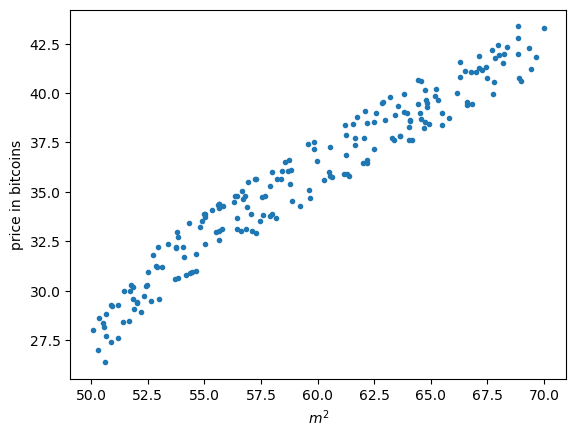

In [16]:
plt.plot(x,y, '.')
plt.xlabel("$m^2$")
plt.ylabel("price in bitcoins")
plt.show()

Ok, we created a dataset (a fake one, but perfect for this exercise). Now let's create a perceptron that will solve this task. Which activation function should be used?

In [17]:
np.random.seed(0)
model = Sequential()
model.add(Dense(1, input_shape=(1,))) #now we have only one input parameter
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.predict(x)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


array([[-41.15355 ],
       [-38.089348],
       [-47.52486 ],
       [-38.050056],
       [-39.141445],
       [-46.43353 ],
       [-40.25606 ],
       [-47.40069 ],
       [-51.124683],
       [-43.664665],
       [-42.370335],
       [-41.63391 ],
       [-40.186523],
       [-42.1437  ],
       [-44.597996],
       [-38.439774],
       [-47.94623 ],
       [-42.107292],
       [-48.54911 ],
       [-43.356983],
       [-46.498764],
       [-48.297394],
       [-43.709217],
       [-43.292583],
       [-40.873783],
       [-44.00702 ],
       [-42.980118],
       [-46.130444],
       [-38.896214],
       [-48.490307],
       [-38.64439 ],
       [-39.288055],
       [-42.230183],
       [-47.017887],
       [-52.351757],
       [-41.603516],
       [-46.10978 ],
       [-50.45378 ],
       [-49.20819 ],
       [-40.662327],
       [-42.58519 ],
       [-48.193336],
       [-42.694344],
       [-44.29155 ],
       [-41.055923],
       [-41.62837 ],
       [-49.760845],
       [-50.4

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


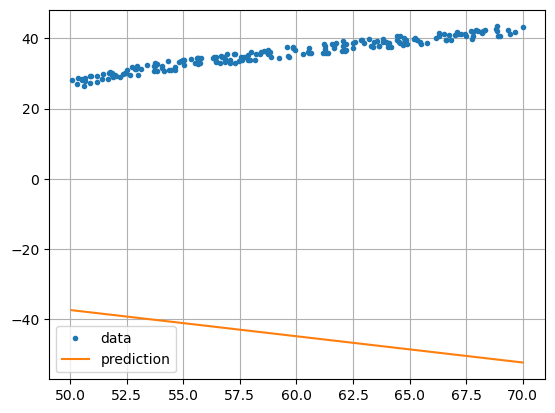

In [19]:
plt.plot(x,y, '.', label='data')
plt.plot(np.sort(x,0), model.predict(np.sort(x,0)), label='prediction')
plt.legend()
plt.grid()
plt.show()

That's our prediction. Probably we are not even close. It's not strange, weights are initialized in a randomized way. What we need now is a measure of this error called a loss function. Once it's defined, the process of training weights is just an optimization task and the goal is to find such weights that minimize the loss function. In fact, any optimization algorithm can be used here including random search - try a lot of random weights and choose the best ones. But in most cases, stochastic gradient descent is used - in this algorithm using derivative iteratively the weights are updated

The first idea might be simply to calculate $prediction - y$. Do you know why it fails? The problem is we will keep a sign so positive and negative errors will cancel each other. We can improve this approach by taking an absolute of it. This metric is called a mean absolute error and again there is one problem. It's not differentiable and some algorithms for optimization require the loss function to be differentiable. That's why we will use the so-called mean squared error $(prediction - y)^2$. It works more or less like mean absolute error + it's differentiable + lower impact of small errors and higher impact of big errors.


In [20]:
mse = lambda x,y: ((y - x)**2).mean() # our loss function

I said you can use even random search so let's give it a try.

In [21]:
bestWeights = model.get_weights()
pred = model.predict(x, verbose=0)
bestError = mse(y, pred)
bestError

for _ in range(200):
    # generate random weights
    weights = [np.random.randn(1,1), np.random.randn(1)]
    # use them in the model
    model.set_weights(weights)
    pred = model.predict(x, verbose=0)
    # evaluate the weights
    err = mse(y, pred)
    if err < bestError:
        bestError = err
        bestWeights = model.get_weights()
        print("Best score so far:", err)


Best score so far: 4891.1249701984525
Best score so far: 618.8097799103092
Best score so far: 431.8615792097705
Best score so far: 96.0190625838139
Best score so far: 82.75324321999865
Best score so far: 62.65741547601692
Best score so far: 4.603000459405834
Best score so far: 4.062428707113407
Best score so far: 1.283453795896516


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


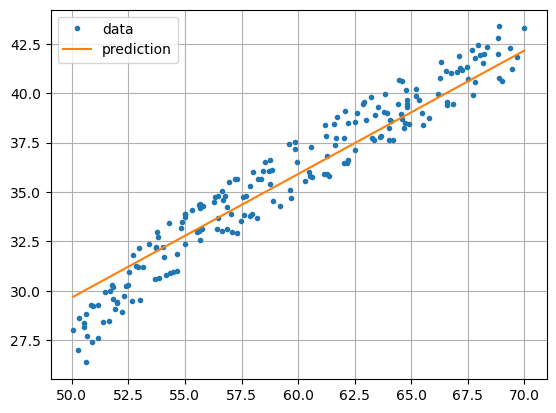

In [22]:
model.set_weights(bestWeights)
plt.plot(x,y, '.', label='data')
plt.plot(np.sort(x,0), model.predict(np.sort(x,0)), label='prediction')
plt.legend()
plt.grid()
plt.show()

Ok, it looks better but there should be a better way than a random search. Of course, there is. As I said before, any optimization technique can be used here but in most cases, a version of stochastic gradient descent is used. Here we take advantage of a differentiable loss function and iteratively step by step change the weights in a direction set by gradient descent.

There are two parameters related to optimizing neural network weights using this algorithm: number of epochs and batch size. The batch size determines the number of rows used for one update of weights. The general rule is the higher the better. The number of epochs determines how many times we will go through the whole dataset in the training process. The total number of weights updates is size of data / batch size * number of epochs

This function is already implemented so we just have to call the fit function. Before we have to call a compile method where we say which loss function should be used and if we want to collect some additional metrics

Epoch 1/300


/home/determinator/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1109.3457 - mae: 33.1036
Epoch 2/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1046.9760 - mae: 32.1144 
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 993.5321 - mae: 31.3253 
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 926.4003 - mae: 30.1904 
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 903.6982 - mae: 29.8612 
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 858.0762 - mae: 29.0779 
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 806.3741 - mae: 28.1729 
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 751.0535 - mae: 27.2095 
Epoch 9/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 723.1564 - mae: 26.6734 
Epoch 10/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 691.6961 - mae: 26.1006 
Epoch 11/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 630.0105 - mae: 24.8773 
Epoch 12/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 601.0134 - mae: 24.3201 

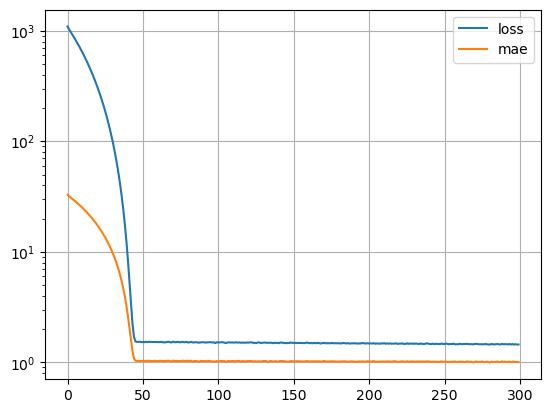

In [23]:
model = Sequential()
model.add(Dense(1, input_shape=(1,)))
model.compile(loss='mse', metrics=['mae'])
history = model.fit(x,y, epochs=300, batch_size=16)
pd.DataFrame(history.history).plot()
plt.grid()
plt.yscale('log')
plt.show()

How to adjust the number of epochs? When you look at the history you should be able to determine when it doesn't make much sense to continue the optimization process. At some point, there is no longer any progress. We can use so-called callbacks - functions executed at various stages of the model training e.g. after each epoch. We can monitor the progress and stop learning when it's not progressing anymore. Such a callback is already implemented and is called EarlyStopping. It can be used together with the ReduceLROnPlateau callback. Before stopping the learning phase first it reduces the learning rate allowing the reduction of loss function even more.

Epoch 1/1000


/home/determinator/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5626.4229 - mae: 74.6052 - learning_rate: 0.0010
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5443.6475 - mae: 73.4146 - learning_rate: 0.0010
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5306.7866 - mae: 72.4224 - learning_rate: 0.0010
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5299.7124 - mae: 72.3836 - learning_rate: 0.0010
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5128.0542 - mae: 71.2159 - learning_rate: 0.0010
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5075.7441 - mae: 70.8658 - learning_rate: 0.0010
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4877.7114 - mae: 69.4750 - learning_rate: 0.0010
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4895.2090 - mae: 69.6014 - learning_rate: 0.0010
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4704.7959 - mae: 68.2393 - learning_rate: 0.0010
Epoch 10/1000
13/13 ━━━━━━━━━━━

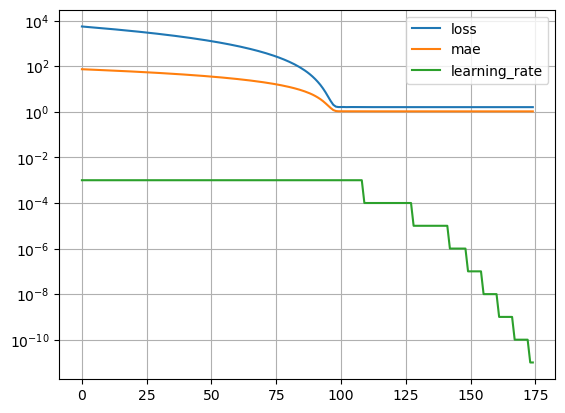

In [24]:
early = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='loss', patience=6)

model = Sequential()
model.add(Dense(1, input_shape=(1,)))
model.compile(loss='mse', metrics=['mae'])
history = model.fit(x,y, epochs=1000, batch_size=16, callbacks=[early, reduce])
history = pd.DataFrame(history.history).plot()
plt.grid()
plt.yscale('log')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


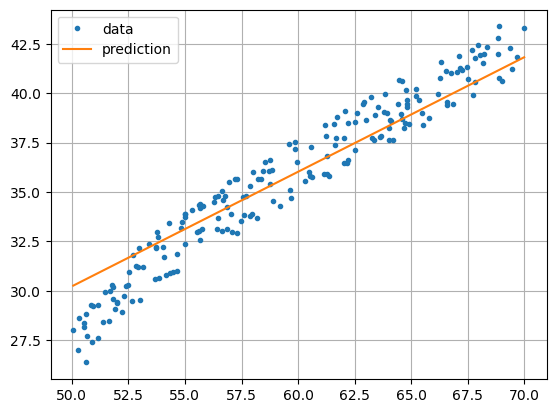

In [25]:
plt.plot(x,y, '.', label='data')
plt.plot(np.sort(x,0), model.predict(np.sort(x,0)), label='prediction')
plt.legend()
plt.grid()
plt.show()

The result is not perfect but with such a model it cannot be better. This model can return only linear output and there isn't a line that will fit much better to the data we have. What we have to do is to extend the model. Let's create a neural network with more than one neuron. Typically in classical neural networks neurons are organized in layers. Outputs of the previous layer is an input for the next layer. All inputs are connected to each neuron from a given layer thus we call such architecture fully connected or dense.


Here we can return to the activation functions.

First, let's list the most popular functions

linear


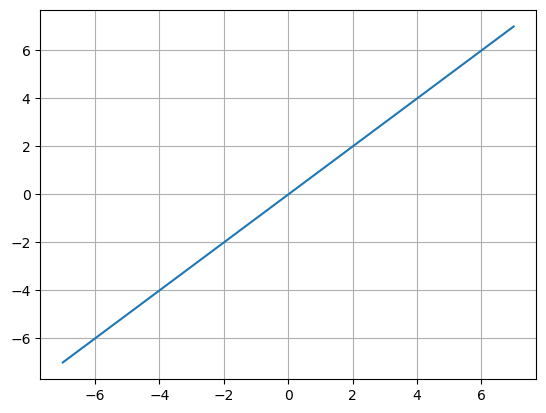

tanh


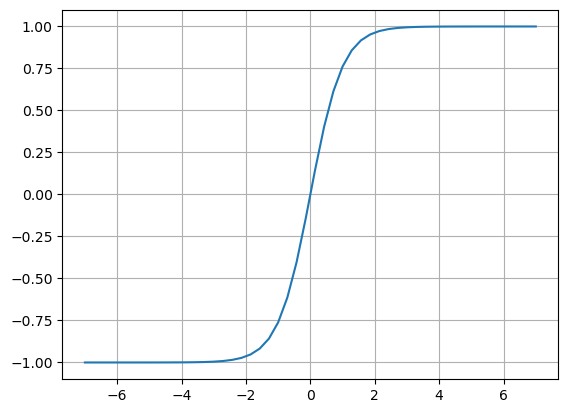

sigmoid


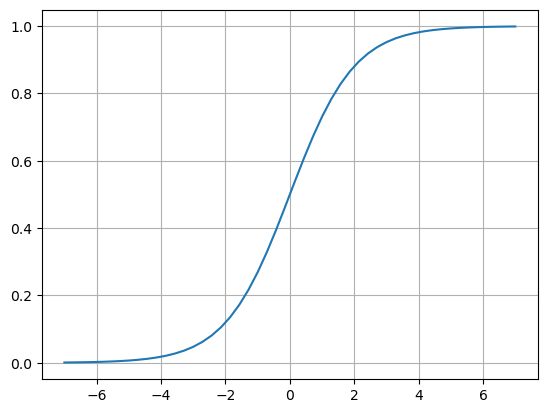

relu


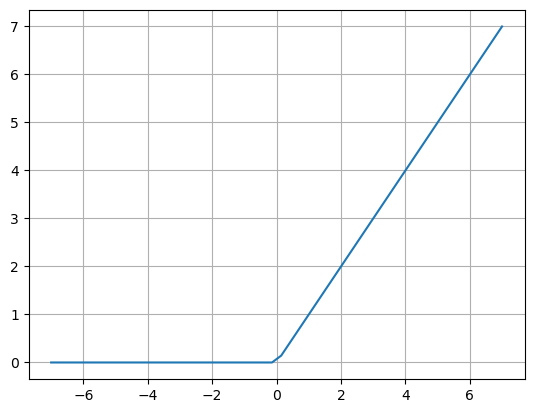

leakyrelu


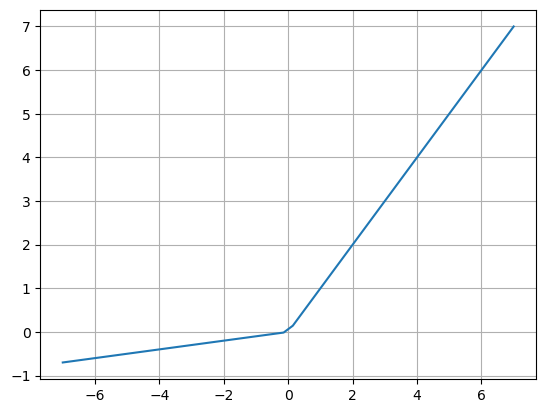

In [26]:
print("linear")
r = np.linspace(-7,7)
plt.plot(r,r)
plt.grid()
plt.show()
print("tanh")
plt.plot(r, np.tanh(r))
plt.grid()
plt.show()
print("sigmoid")
plt.plot(r, 1/(1 + np.exp(-r)))
plt.grid()
plt.show()
print("relu")
plt.plot(r, np.where(r<0,0,r))
plt.grid()
plt.show()
print("leakyrelu")
plt.plot(r, np.where(r<0,r*.1,r))
plt.grid()
plt.show()

Now how to decide which one to use. As you probably noticed some functions have a limited range of values e.g. sigmoid returns values from 0 to 1 hence it's a perfect option when the output should be treated as a probability.

In dense layers it doesn't make much sense to use linear activation. Do you know why? What's a linear transformation of linear transformation?

Good default choice is relu

The process of weight selection uses the derivative of an activation function. As you probably noticed for most of them derivative is close to zero for big positive and negative values. That's why we want to stay close to 0. To achieve that it's a good practice to introduce a data scaling process. It's a good idea to try different options, but classical standardization should be enough in most cases

In [27]:
ss_x = StandardScaler()
ss_y = StandardScaler()

transformed_x = ss_x.fit_transform(x)
transformed_y = ss_y.fit_transform(y)

In [28]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(1,))) # 64 neurons in the first layer
model.add(Dense(1)) # no need to specify input shape. Why?

model.compile(loss='mse', metrics=['mae'])

early = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='loss', patience=6)

model.fit(transformed_x,transformed_y, epochs=500, batch_size=16, callbacks=[early, reduce])

Epoch 1/500


/home/determinator/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.1061 - mae: 0.8730 - learning_rate: 0.0010
Epoch 2/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7987 - mae: 0.7409 - learning_rate: 0.0010
Epoch 3/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6053 - mae: 0.6352 - learning_rate: 0.0010
Epoch 4/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4802 - mae: 0.5641 - learning_rate: 0.0010
Epoch 5/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2785 - mae: 0.4067 - learning_rate: 0.0010
Epoch 6/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1900 - mae: 0.3461 - learning_rate: 0.0010
Epoch 7/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1336 - mae: 0.2928 - learning_rate: 0.0010
Epoch 8/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1163 - mae: 0.2681 - learning_rate: 0.0010
Epoch 9/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0927 - mae: 0.2582 - learning_rate: 0.0010
Epoch 10/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0794 - mae: 0

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


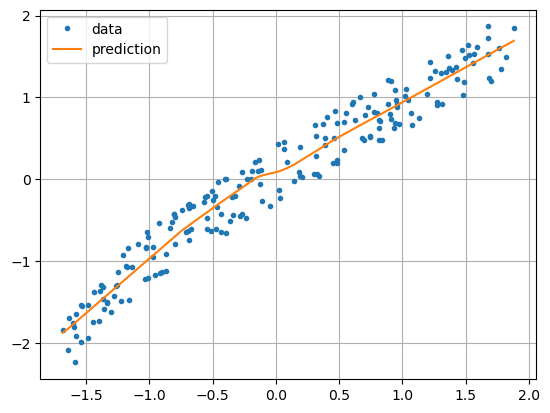

In [29]:
plt.plot(transformed_x,transformed_y, '.', label='data')
plt.plot(np.sort(transformed_x, 0), model.predict(np.sort(transformed_x, 0)), label='prediction')
plt.legend()
plt.grid()
plt.show()

You might wonder why do we use sort for plotting the prediction. Well it's just to draw a nice line. When the points are in a random order and we plot lines between them it might be quite chaotic.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


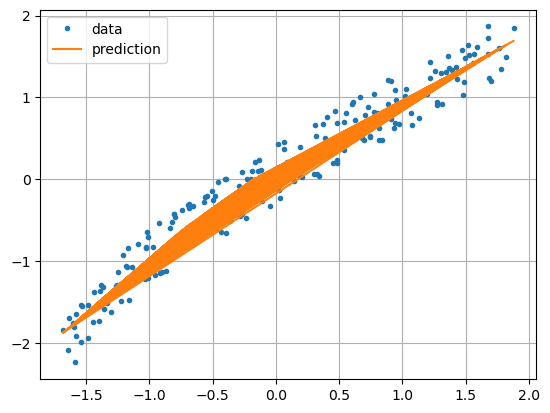

In [30]:
plt.plot(transformed_x,transformed_y, '.', label='data')
plt.plot(transformed_x, model.predict(transformed_x), label='prediction')
plt.legend()
plt.grid()
plt.show()

To avoid it we can just plot points, but a line looks better

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


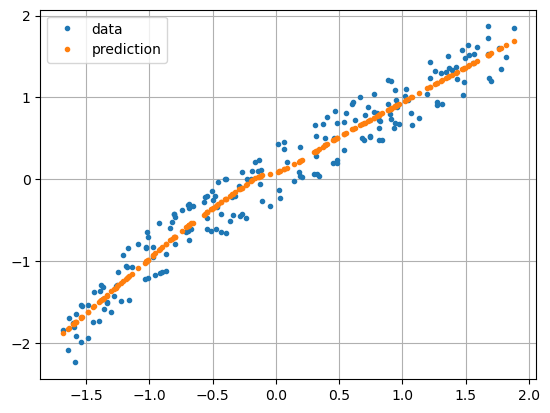

In [31]:
plt.plot(transformed_x,transformed_y, '.', label='data')
plt.plot(transformed_x, model.predict(transformed_x), '.', label='prediction')
plt.legend()
plt.grid()
plt.show()

# Task 1
What's the best architecture? Play here https://playground.tensorflow.org/

# Task 2
Try different architectures. Use different number of layers, neurons, activation functions

Selecting the best number of layers and neurons is an optimization task itself. There are no strict rules. In general, you should increase the number of neurons as long as it improves the results. Be aware of overfitting - model learning noise in the data. Always split dataset to train, validation and training.

Remember even the most complex network works still like a single perceptron - it's just an equation with weights determined using an optimization algorithm.

Lifehack: since selecting architecture is an optimization task we can use an optimization algorithm to solve it. The most obvious representation would be a vector of size equal to the maximum number of layers we want and each element representing the number of neurons in such a layer. There are a few problems with this approach - it doesn't make sense to have neurons in the next layer if we have 0 neurons in the previous which is allowed in this representation. Removing 0 from the considered range is an option but then we will fix the number of layers. Also in most cases, it's not recommended to increase the number of neurons in the next layer. To avoid these issues we can change the representation. The first element will still be the number of neurons in the first layer, but all remainings will be the number from 0 to 1 meaning the fraction of neurons from the previous layer used in this layer. For example $[64, 1, .5, .5, 0, 0]$ would mean architecture with 4 layers with 64, 64, 32, and 16 neurons.

To avoid overfitting we split our dataset to training, validation, and test sets. It's a good practice in most cases to shuffle the data  since the initial order might have some problems. For example data can be sorted by a target value. Then if we split it in half, the testing set might contains target that are not in the training set

In [32]:
np.random.seed(31)
idx = np.arange(len(x))
np.random.shuffle(idx)
idx

array([148,   8,  79, 137, 147, 102, 179,  41,  56,  55,  45, 169, 139,
       189, 118,  17,  10, 157,  96,  43,  74, 110,  95, 142,  12,  88,
        54, 167, 185, 149,  53,  80, 197,  36,  62, 193,   2, 161, 109,
       163,  37, 184, 192, 168,  71,  72, 144, 150,  68, 160, 123,  70,
        77, 175,  48, 136, 131, 117,  21,  33,  13,  15,  47,  40, 143,
        73, 114,  64, 129,  50,  23,  14,  89,  35, 134,  66,  19, 154,
        49,  65,  67,  84, 108,  63, 187,  69,  83, 130,  59,   0, 105,
       177, 141, 100,  32, 127,  57,   3, 199, 173,  38, 128,   7, 121,
         4,  39, 101,  31, 125, 164,  34, 183,  44,  85, 196,  27,  78,
        86, 165,  20,  61, 153,  22,  60,   5,  30,  91,  18, 135, 124,
        75, 162,  94,  90, 198, 182,  42, 166, 174, 132,   9,  93, 133,
        29, 145,  51, 190, 158,  26, 180, 104, 115, 112, 181,  11, 178,
       188, 119,  24, 140,  76,  97,   1, 194, 116, 171,  52, 155, 106,
       159, 120, 111, 103, 152, 186, 176,  99, 172, 191, 113, 13

In [33]:
train = idx[:int(.8*len(x))]
val = idx[int(.8*len(x)):int(.9*len(x))]
test = idx[int(.9*len(x)):]

In [34]:
train_x, train_y = transformed_x[train], transformed_y[train]
val_x, val_y = transformed_x[val], transformed_y[val]
test_x, test_y = transformed_x[test], transformed_y[test]

What's the problem here? Well it's not a big issue, but data from validation and test sets should not be used to determine scaling parameters. So the scaler should be fit on the training data and then applied to validation and test datasets. Can you do it now?

In [35]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(1,)))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=['mae'])

early = EarlyStopping(patience=15, restore_best_weights=True) # we don't specify monitor, by default it's val_loss
reduce = ReduceLROnPlateau(patience=6)

model.fit(train_x,train_y, validation_data=(val_x, val_y), epochs=500, batch_size=16, callbacks=[early, reduce])

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.6338 - mae: 0.6659 - val_loss: 0.5268 - val_mae: 0.5980 - learning_rate: 0.0010
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3763 - mae: 0.5004 - val_loss: 0.3626 - val_mae: 0.4903 - learning_rate: 0.0010
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2466 - mae: 0.4034 - val_loss: 0.2491 - val_mae: 0.3990 - learning_rate: 0.0010
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1972 - mae: 0.3616 - val_loss: 0.1744 - val_mae: 0.3257 - learning_rate: 0.0010
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1531 - mae: 0.3202 - val_loss: 0.1294 - val_mae: 0.2728 - learning_rate: 0.0010
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1046 - mae: 0.2698 - val_loss: 0.1016 - val_mae: 0.2444 - learning_rate: 0.0010
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0884 - mae: 0.2504 - val_loss: 0.0861 - val_mae: 0.2242 - learning_rate: 0.0010
Epoch 8/500


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


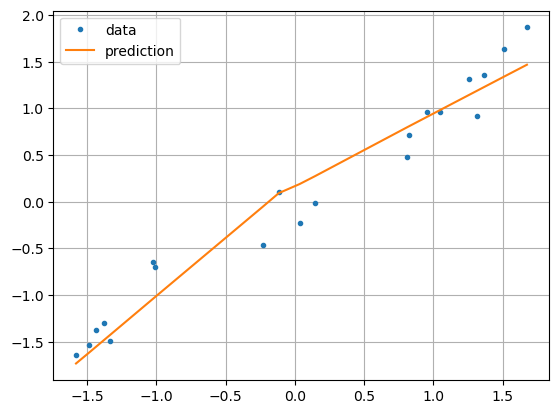

In [36]:

plt.plot(test_x,test_y, '.', label='data')
plt.plot(np.sort(test_x, 0), model.predict(np.sort(test_x, 0)), label='prediction')
plt.legend()
plt.grid()
plt.show()

There are two popular functions to create a neural network model. For simple architectures Sequential can be used. For more complex Model is a suitable choice.


In the sequential model, we assume layers are executed sequentially one by one. In Model, we can create architectures with different connections, multiple inputs or outputs.

In [37]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(1,)))
model.add(Dense(32, activation='relu', input_shape=(1,)))
model.add(Dense(16, activation='relu', input_shape=(1,)))
model.add(Dense(1, activation='linear'))

In [38]:
plot_model(model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [39]:
inputLayer = Input(shape=(1,))
dense1 = Dense(64, activation='relu')(inputLayer)
dense2 = Dense(32, activation='relu')(dense1)
dense3 = Dense(16, activation='relu')(dense2)
dense4 = Dense(1, activation='relu')(dense3)
model = Model(inputs=inputLayer, outputs=dense4)

In [40]:
plot_model(model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [41]:
inputLayer = Input(shape=(1,))
dense1 = Dense(64, activation='relu')(inputLayer)
dense2 = Dense(32, activation='relu')(dense1)
concat = Concatenate()([dense1, dense2])
dense3 = Dense(16, activation='relu')(concat)
dense4 = Dense(1, activation='relu')(dense3)
model = Model(inputs=inputLayer, outputs=dense4)

In [42]:
plot_model(model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


# Task 3
Create a model with two inputs, first processed by three Dense layers, second by two Dense layers, then concatenat them, process by two Dense layers and split it to two outputs

Data generators are useful tools for neural network training. It allows to create data separately for each batch. Thanks to that there is no need to load all the data to the memory, which can be an issue for example when dealing with images. Also when we don't have data but a function creating data then instead of generating a fixed number of rows in advance a data generator can be used. It's also useful for the data augmentation process.

In [43]:
class DataGenerator(Sequence):
    def __init__(self, x, y, batch_size, shuffle=True):
        self.x = x
        self.y = y
        self.indexes = np.arange(len(y))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.indexes) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch.
        # During training and prediction this function will be called in range(0, __len__())
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, idx):
        X = np.empty((self.batch_size, 1))
        y = np.empty((self.batch_size), )

        for i, ID in enumerate(idx):
            # Store sample
            X[i,] = self.x[ID]

            # Store class
            y[i] = self.y[ID]

        return X, y

In [44]:
trainGenerator = DataGenerator(train_x, train_y, 16)
valGenerator = DataGenerator(val_x, val_y, 1, shuffle=False)

In [45]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(1,)))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=['mae'])

early = EarlyStopping(patience=15, restore_best_weights=True) # we don't specify monitor, by default it's val_loss
reduce = ReduceLROnPlateau(patience=6)

model.fit(trainGenerator, validation_data=valGenerator, epochs=500, batch_size=16, callbacks=[early, reduce])

Epoch 1/500


/home/determinator/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/tmp/ipykernel_21520/1683743351.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = self.y[ID]


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.8530 - mae: 0.7698 - val_loss: 0.5835 - val_mae: 0.6211 - learning_rate: 0.0010
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5066 - mae: 0.5863 - val_loss: 0.4203 - val_mae: 0.5244 - learning_rate: 0.0010
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3363 - mae: 0.4589 - val_loss: 0.3033 - val_mae: 0.4397 - learning_rate: 0.0010
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2659 - mae: 0.4269 - val_loss: 0.2186 - val_mae: 0.3635 - learning_rate: 0.0010
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1658 - mae: 0.3368 - val_loss: 0.1546 - val_mae: 0.3075 - learning_rate: 0.0010
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1377 - mae: 0.3030 - val_loss: 0.1177 - val_mae: 0.2730 - learning_rate: 0.0010
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1014 - mae: 0.2702 - val_loss: 0.0931 - val_mae: 0.2450 - learning_rate: 0.0010
Epoch 8/500
10/10 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


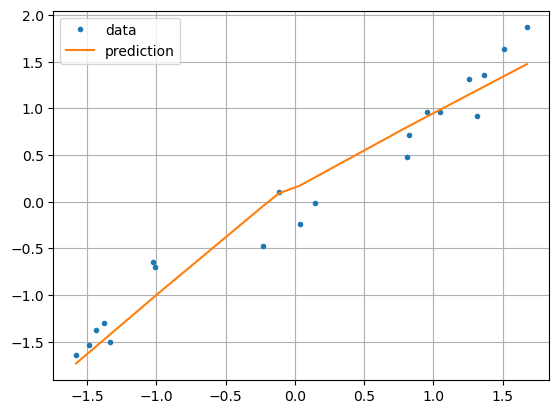

In [46]:
plt.plot(test_x,test_y, '.', label='data')
plt.plot(np.sort(test_x, 0), model.predict(np.sort(test_x, 0)), label='prediction')
plt.legend()
plt.grid()
plt.show()

Of course, this generator doesn't make much sense since the data are already in the memory and we don't do anything with them. It's just a template you can use later when it's really needed.

# Task 4
Predict the quality of wine using neural network.
 - Treat target as continuous.
 - Treat target as discrete classes.

In [47]:
data = load_wine()

In [48]:
x = data['data']
y = data['target']

In [49]:
x

array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
        1.065e+03],
       [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
        1.050e+03],
       [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
        1.185e+03],
       ...,
       [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
        8.350e+02],
       [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
        8.400e+02],
       [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
        5.600e+02]])

In [50]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

Here spliting into train, val, and test sets without shuffling might not be the best idea

In [51]:
#try also this model
#check why and how it works
model = Sequential()
model.add(Dense(16, 'relu', input_shape=(13,)))
model.add(Dense(3, 'softmax'))
model.compile(loss='sparse_categorical_crossentropy', metrics=['acc'])

/home/determinator/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Project


In [52]:
df = pd.DataFrame({'pActive': [0.7, 0.2], 'popularity': [0.1, 0.4]})
df

,pActive,popularity
0,0.7,0.1
1,0.2,0.4


Consider a simplified model for the election in the NPOS cryptocurrency environment. A nominator can select up to 16 different validators. Each validator has a probability to become active called $pActive$. Then the nominator will get assigned to one of the selected active validators in such a way that distributes stakes (money) between validators evenly. Therefore the more popular a validator is, the lower probability to be assigned to them.

Example:

With two validators having $pActive$ 0.7 and 0.2 and $popularity$ 0.1 and 0.4 respectively there are 4 possible scenarios:

 - no validators being active p = (1-0.7) * (1-0.2) = 0.24
 - just validator A p = 0.7 * (1-0.2) = 0.56
 - just validator B p = (1-0.7) * 0.2 = 0.06
 - both validators active p = 0.7 * 0.2 = 0.14

In the first scenario there are no candidates so nobody is assigned. In the second and third case there is just once candidate so with 100% probability she/he wins. The last scenario is the most complex and we have to account for popularity and validator A has 20% chances of wining and B 80%. Combining all scenarios

 - validator A: 0.56 * 100% + 0.14 * 20% = 58.8%
 - validator B: 0.06 * 100% + 0.14 * 80% = 17.2%

We can write a function to calculate it


In [53]:
def getProbability(df):
    combinations = np.indices((2,) * len(df)).reshape(len(df), -1).T.astype(int)
    p = np.maximum((1-combinations)*(1-df.pActive.values), (combinations*df.pActive.values)).prod(1)
    prob = (combinations * df.popularity.values)[1:] / (combinations * df.popularity.values).sum(1).reshape((-1,1))[1:]
    x=(p.reshape((-1,1))[1:] * prob)

    return x.sum(axis=0)

In [54]:
getProbability(df)

array([0.588, 0.172])

In [55]:
np.random.seed(44)
df = pd.DataFrame({'pActive': np.random.rand(16), 'popularity': np.random.rand(16)})
df

,pActive,popularity
0,0.834842,0.943351
1,0.104796,0.881824
2,0.744640,0.646411
3,0.360501,0.213825
4,0.359311,0.636832
5,0.609238,0.139146
6,0.393780,0.458704
7,0.409073,0.873863
8,0.509902,0.258450
9,0.710148,0.664851


In [56]:
getProbability(df)

array([0.18913886, 0.01923229, 0.11579273, 0.01878055, 0.05184979,
       0.02111685, 0.04234469, 0.07859714, 0.03217675, 0.11270273,
       0.20698343, 0.01681029, 0.05573447, 0.00439729, 0.00918603,
       0.02515601])

It might take longer when more candidates are considered. Imagine you have to solve an optimization problem where this function will be executed millions of times thus we want to make it faster.

Your task is to create a neural network estimating function $getProbability$, while being much faster. You can assume the maximum number of validators is 16 and the minimal is 1. $pActive$ is in range from 0 to 1 $popularity$ is greater than 0 without an upper limit. Keep in mind it's possible no validator will be active (scenario 1 in the example above).
Try to avoide using heavy pre- and post-processing (do not put a whole logic of the function there) and do as much computations as possible inside the neural network


Send your result by the end of 26th October to grzegorz.miebs@cs.put.poznan.pl, start the email subject with [DL], there should be a function named project1 that gets a DataFrame as a parameter and produces a numpy array with probabilities.


In [65]:
def generate_data(n_samples=10000):
    X_list = []
    y_list = []

    for _ in range(n_samples):
        n_validators = np.random.randint(1, 17)

        pActive = np.random.rand(n_validators)

        popularity = np.clip(np.random.rand(n_validators) + 0.01, 0.01, 1)

        df = pd.DataFrame({'pActive': pActive, 'popularity': popularity})

        probabilities = getProbability(df)

        pActive_padded = np.pad(pActive, (0, 16 - n_validators), constant_values=0)
        popularity_padded = np.pad(popularity, (0, 16 - n_validators), constant_values=0)
        probabilities_padded = np.pad(probabilities, (0, 16 - n_validators), constant_values=0)

        X = np.concatenate([pActive_padded, popularity_padded])

        X_list.append(X)
        y_list.append(probabilities_padded)

    return np.array(X_list), np.array(y_list)

In [64]:
def evaluate_model(df):
    n_validators = len(df)

    pActive = df['pActive'].values
    popularity = df['popularity'].values

    pActive_padded = np.pad(pActive, (0, 16 - n_validators), constant_values=0)
    popularity_padded = np.pad(popularity, (0, 16 - n_validators), constant_values=0)

    X = np.concatenate([pActive_padded, popularity_padded]).reshape(1, -1)

    predictions = model.predict(X, verbose=0)[0]

    return predictions[:n_validators]

Epoch 1/50


2025-10-15 01:16:42.692925: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_279', 8 bytes spill stores, 8 bytes spill loads

2025-10-15 01:16:43.432544: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_279', 104 bytes spill stores, 104 bytes spill loads

2025-10-15 01:16:43.475230: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_286', 24 bytes spill stores, 24 bytes spill loads

2025-10-15 01:16:44.525425: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_286', 24 bytes spill stores, 24 bytes spill loads

2025-10-15 01:16:44.588279: I external/local

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3033 - loss: 0.0283 - mae: 0.0934 - mse: 0.0283 - val_accuracy: 0.5573 - val_loss: 0.0039 - val_mae: 0.0310 - val_mse: 0.0039 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6324 - loss: 0.0031 - mae: 0.0279 - mse: 0.0031 - val_accuracy: 0.7933 - val_loss: 7.4958e-04 - val_mae: 0.0166 - val_mse: 7.4958e-04 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8298 - loss: 5.8343e-04 - mae: 0.0147 - mse: 5.8343e-04 - val_accuracy: 0.8811 - val_loss: 3.4374e-04 - val_mae: 0.0116 - val_mse: 3.4374e-04 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8799 - loss: 3.4241e-04 - mae: 0.0115 - mse: 3.4241e-04 - val_accuracy: 0.8957 - val_loss: 2.7797e-04 - val_mae: 0.0104 - val_mse: 2.7797e-04 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8918 - loss: 2.8326e-04 - mae: 0.0105 - 

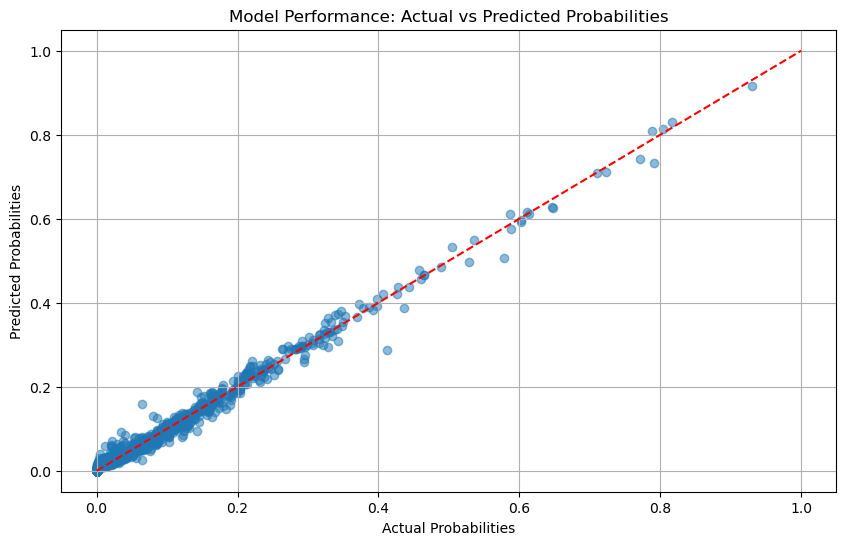

In [70]:
# 1. Generate training data
X_train, Y_train = generate_data(50000)

# 2. Create model
model = Sequential([
    Input(shape=(32,)),
    Dense(128, 'relu'),
    Dense(128, 'relu'),
    Dense(64, 'relu'),
    Dense(16, 'sigmoid')
])
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse', 'accuracy'])

# 3. Train with callbacks
early = EarlyStopping(patience=10, restore_best_weights=True)
reduce = ReduceLROnPlateau(patience=5)
history = model.fit(X_train, Y_train, epochs=50, batch_size=64,
                    validation_split=0.2, callbacks=[early, reduce])

# 4. Generate test data with various validator counts
print("Generating test data...")
X_val, actual = generate_data(100)

# 5. Calculate and display overall metrics
print("Evaluating model...")
predictions = model.predict(X_val)

# Create a scatter plot of actual vs predicted probabilities
plt.figure(figsize=(10, 6))
plt.scatter(actual.flatten(), predictions.flatten(), alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line represents perfect predictions
plt.xlabel('Actual Probabilities')
plt.ylabel('Predicted Probabilities')
plt.title('Model Performance: Actual vs Predicted Probabilities')
plt.grid(True)
plt.show()